In [ ]:
# As the data processing will be pretty expensive in computation terms,
# the process was made in the Google Colab workspace so the data is stored in Google Drive
# to process the data at a local level or using data from a different source,
# the route must be changed

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#**********************************************************************************************
# @Name: Computation of the Passengers load by hour and link
# @Author: Team 21
# @Date: 2020/10/31 11:07:13
# @Help: 
#**********************************************************************************************

# Libraries import ----------------------------------------------------------------------------
import pandas as pd                   # Data manipulation
import numpy as np                    # Numeric manipulation
import os, glob                       # System management

# Process detail ------------------------------------------------------------------------------
# Calculation of passenger load per day, per hour, per link.
# The mechanism to obtaining the data (GPS positioning system in each vehicle
# from the articulated transport network to the electronic meter on the front and rear doors)
# transmits in real time to the entity's database the registration and location of the event
# of passenger movement in real time and at a specific point in space.
# The main problem of this information collection mechanism is the error in the measurements
# of the number of passengers getting on or off a vehicle. The error becomes significant when
# We calculate the passenger load in each link that makes up a route, since the value depends on
# of the values calculated in the previous links

# Development ----------------------------------------------------------------------------------
path = "/content/drive/My Drive/ds4a-project/outputs/"
path_to = "/content/drive/My Drive/ds4a-project/stats/load_by_link/"

# Files list to process
list_files = [f for f in os.listdir(path) if f.endswith('.csv')]
list_files.sort()

In [ ]:
alldays = []

for i, file in enumerate(list_files):
  print(f'Processing: {file}. File {i+1} of {len(list_files)}')

  # Reading the data
  oneday = pd.read_csv(path + file, usecols = ['DATEKEY', 'CODIGORUTA', 'SECUENCIARECORRIDO', 'FECHAREGISTRO', 'HOUR', 'LINK', 'PAXUP', 'PAXDW', 'FAR'])

  # Reading just the likely events (those within the AMVA)
  oneday = oneday[oneday['FAR'] == False]
  # oneday = oneday[(oneday['PAXUP'] < 50) & (oneday['PAXDW'] < 50) ]
  try: 
  # The passengers load of a vehicle at a time t is equal to the boardings minus the alightings plus the load of the previous link
    oneday['CARGA'] = oneday['PAXUP'] - oneday['PAXDW']
    #> Dataset by the relevant variables 
    oneday = oneday.sort_values(by = ['CODIGORUTA','SECUENCIARECORRIDO','FECHAREGISTRO'])
    #> The load is computed by trip, i.e., we take into account that the passengers load of a link at a given time depends on the passengers load
    # of the previous link in the sequence of the trip route.
    grp = oneday.groupby(['CODIGORUTA', 'SECUENCIARECORRIDO'])
    oneday['CARGA'] = np.concatenate([np.cumsum(CARGA.values) for i, CARGA in grp['CARGA']])

    # Passengers load by date, hour and link
    alldays.append(oneday.groupby(['DATEKEY', 'HOUR', 'LINK'], as_index = False).agg({'CARGA': 'sum'}))
  except: continue

pd.concat(alldays, axis = 0, ignore_index = True).to_csv(path_to + 'load_by_link.csv', index = False)

## Calculation of passenger load and findings in the data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<p>We will show some of the inconveniences that arose in the calculation of the passenger load per day, hour and link due to the fact that the passenger movement is wrong. Basically, the message is that any measurement error accumulates throughout the entire route of a vehicle that covers some route, on a day of public transport service.</p>
<p>A route consists of the succession of links (pairs of nodes) from the beginning to the end, therefore, if in any vehicle trip there is a measurement error in the first links of the route, any calculation of the load of passengers on a later link will be affected. That said, let's go into detail:</p>

### A single day of information


<p>We upload a csv file that records all trips and passenger movement events for a single day, for example: November 15, 2019. The file was previously cleaned and manipulated to show relevant information in its columns, in addition, to each passenger movement event has been assigned the closest link according to its geographic coordinates.</p>

In [ ]:
oneday = pd.read_csv(path + '20191116.csv', usecols = ['DATEKEY', 'CODIGORUTA', 'SECUENCIARECORRIDO', 'IDVEHICULO', 'FECHAREGISTRO', 'HOUR', 'LINK', 'PAXUP', 'PAXDW', 'FAR'])
oneday = oneday.sort_values(by = ['CODIGORUTA','SECUENCIARECORRIDO', 'IDVEHICULO', 'FECHAREGISTRO', 'HOUR'])
oneday.head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK
21,139472271,491,1001,2019-11-16 02:46:56,20191116,2,0,1,False,3776-3772
22,139472271,491,1001,2019-11-16 02:47:25,20191116,2,0,1,False,3776-3772
5061,139508261,399,1001,2019-11-16 05:27:35,20191116,5,3,1,False,3776-3774
5062,139508261,399,1001,2019-11-16 05:27:44,20191116,5,1,0,False,3776-3774
5063,139508261,399,1001,2019-11-16 05:28:13,20191116,5,0,1,False,3776-3772
5064,139508261,399,1001,2019-11-16 05:41:40,20191116,5,2,1,False,3776-3774
5065,139508261,399,1001,2019-11-16 05:42:39,20191116,5,1,0,False,5406-5316
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007


<p>The <code>SECUENCIARECORRIDO</code>, <code>IDVEHICULO</code>, and <code>CODIGORUTA</code> columns identify a certain route made by a vehicle. The <code>PAXUP</code> and <code>PAXDW</code> columns record the number of passengers who boarded and alighted from the vehicle. The <code>FAR</code> column indicates if the registered event occurred more than one kilometer away from the closest link and <code>LINK</code> shows the identifier of the closest link for each event. The LINK column is essential because it associates each passenger movement event to a specific point in the Valle de Aburrá transport network, which in turn allows to approximate the number of passengers getting on and off the vehicles in one place, day and specific time.</p>
<p>The first thing we notice is a trip (identified as 139472271) recorded at an unconventional time and with a duration of less than 2 minutes. These types of records are very common on other routes, other trips and on other days. Furthermore, the record indicates that 2 passengers got off (<code>PAXDW = 2</code>) when in fact none got on (<code>PAXUP = 0</code>). The recording of events at unconventional hours and trips that transmit intermittent or incomplete information along a route is a pervasive problem in the data set.</p>

### Unexpected alightings

<p>Let's now see a trip that seems to be complete, for example the one identified as 139526583, made by vehicle 6106 and that covers route 1001. The trip begins around 5 a.m. and reports the descent of four passengers and then two in the link 5404 -5405 and 5405-7007, despite the fact that no passengers boarded before. This point is key: complete trips, in conventional hours, report passenger alightings at the beginning of the route, this means that the calculated passenger load is negative in the initial links. If we add all the trips that pass through these links and if the majority report a negative load calculation, we will obtain that the total volume of passengers is negative.</p>

In [ ]:
oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106').head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007
13269,139526583,6106,1001,2019-11-16 04:57:21,20191116,4,4,7,False,7007-5405
13270,139526583,6106,1001,2019-11-16 04:58:19,20191116,4,2,1,False,7032-7033
13271,139526583,6106,1001,2019-11-16 04:58:48,20191116,4,3,14,False,7032-7033
13272,139526583,6106,1001,2019-11-16 04:59:17,20191116,4,3,9,False,7029-7030
13273,139526583,6106,1001,2019-11-16 04:59:46,20191116,4,4,9,False,7029-7030
13274,139526583,6106,1001,2019-11-16 05:00:15,20191116,5,2,9,False,7029-7030
13275,139526583,6106,1001,2019-11-16 05:00:44,20191116,5,1,2,False,7030-7029


<p>Let's calculate the passenger load for the trip in our example and see what happens to the measurement errors.</p>

In [ ]:
oneday['CARGA'] = oneday['PAXUP'] - oneday['PAXDW']
grp = oneday.groupby(['CODIGORUTA', 'SECUENCIARECORRIDO', 'IDVEHICULO'])
oneday['CARGA'] = np.concatenate([np.cumsum(CARGA.values) for i, CARGA in grp['CARGA']])
oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106').head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK,CARGA
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405,-4
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007,-6
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007,-5
13269,139526583,6106,1001,2019-11-16 04:57:21,20191116,4,4,7,False,7007-5405,-8
13270,139526583,6106,1001,2019-11-16 04:58:19,20191116,4,2,1,False,7032-7033,-7
13271,139526583,6106,1001,2019-11-16 04:58:48,20191116,4,3,14,False,7032-7033,-18
13272,139526583,6106,1001,2019-11-16 04:59:17,20191116,4,3,9,False,7029-7030,-24
13273,139526583,6106,1001,2019-11-16 04:59:46,20191116,4,4,9,False,7029-7030,-29
13274,139526583,6106,1001,2019-11-16 05:00:15,20191116,5,2,9,False,7029-7030,-36
13275,139526583,6106,1001,2019-11-16 05:00:44,20191116,5,1,2,False,7030-7029,-37


<p>The <code>CARGA</code> column returns the passenger load after each passenger movement event. Obviously something is wrong with the data: a negative load is impossible. But beyond that, let's look at how the measurement error accumulates throughout the trip and in each link on the route. First, the number -6 (second row of the <code>CARGA</code> column) means that on the LINK 5405-7007 there are -6 passengers inside the vehicle. When the next event is presented on the same link (three people go up <code>PAXUP = 3</code>, two people go down <code>PAXDW = 2</code>) the balance continues to be negative regardless of whether the event registration was correct this time. So, for this trip the results would be: passenger load of -5 in the link 5405-7007, and passenger load of -8 in the following link 7007-5405 (-5 of the previous link plus a net movement of - 3).</p>
<p>Note that the passenger load of a link depends on the passenger load of the immediately previous link. Formally, for a single trip, of a certain vehicle, on a certain route, on a given day, the passenger load of link i is equal to the passenger load of link i-1 plus the net movement of passengers occurred in link i.</p>

### Negative passengers load 

<p>Now let's look at the end of the travel. This began around 5 am. and ended at 6:20 am. The load of the last link of the route (identified 3776-3774) is -360 passengers, that is, measurement errors (more passengers get off than going up) accumulated during an hour and twenty minutes of travel throughout the entire route. Successive negative loads will result in excessive negative loads in the end. If we add these results with the results of other trips on other routes that pass through the same links for a given day and time, the negative amounts will cancel out with the positive ones or the negative amounts will grow even more.</p>

In [ ]:
oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106')

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK,CARGA
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405,-4
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007,-6
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007,-5
13269,139526583,6106,1001,2019-11-16 04:57:21,20191116,4,4,7,False,7007-5405,-8
13270,139526583,6106,1001,2019-11-16 04:58:19,20191116,4,2,1,False,7032-7033,-7
...,...,...,...,...,...,...,...,...,...,...,...
13447,139526583,6106,1001,2019-11-16 06:19:22,20191116,6,0,1,False,3776-5316,-360
13448,139526583,6106,1001,2019-11-16 06:20:20,20191116,6,2,3,False,3776-3774,-361
13449,139526583,6106,1001,2019-11-16 06:20:49,20191116,6,5,4,False,3776-3774,-360
13450,139526583,6106,1001,2019-11-16 06:21:07,20191116,6,3,4,False,3776-3772,-361


<p>Let us also observe that the number of passengers who got off the vehicle took on plausible values ​​throughout the trip (between 0 and 12) and that in most of the events between two and four people got off. However, the passenger load at the end of the trip was -360, instead of zero (the vehicle must be empty when the trip ends).</p>

In [ ]:
print(oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106').PAXDW.value_counts())

4     30
2     30
3     27
1     27
5     17
0     16
6     13
9      7
7      7
10     4
11     3
14     2
8      2
12     1
Name: PAXDW, dtype: int64


<p>Passengers alightings at the beginning of a trip may not be the main problem. In the fragment of the dataset presented below, we note that the trip 139959191 begins with a alighting of 76 passengers, this number will completely ruin any calculation.</p>
<p>In general, an extreme value in both the number of passengers who get on and those who get off seriously distorts the calculation of the load of passengers in a link and in those that follow along the route of the vehicle. Again, imagine that we add these results to approximate the volume of passengers in any day and hour of operation in a certain link, the result obtained will be uninformative. It should be noted that values ​​greater than 50 in the <code>PAXUP</code> and <code>PAXDW</code> columns represent less than 1% of the distribution of these variables; however, the accumulated negative effect they produce in the calculations is large.</p>

In [ ]:
oneday.query('SECUENCIARECORRIDO == 139959191 & IDVEHICULO == 566').head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK,CARGA
303069,139959191,566,1018,2019-11-16 17:52:10,20191116,17,0,76,False,5293-5388,-76
303076,139959191,566,1018,2019-11-16 18:08:03,20191116,18,1,0,False,3718-7050,-75
303078,139959191,566,1018,2019-11-16 18:11:27,20191116,18,1,0,False,5648-3005,-74
303079,139959191,566,1018,2019-11-16 18:14:23,20191116,18,1,0,False,5651-3790,-73
303082,139959191,566,1018,2019-11-16 18:17:17,20191116,18,0,1,False,3784-3783,-74
303083,139959191,566,1018,2019-11-16 18:18:36,20191116,18,1,0,False,2086-2087,-73
303084,139959191,566,1018,2019-11-16 18:25:23,20191116,18,1,1,False,3229-2353,-73
303085,139959191,566,1018,2019-11-16 18:27:17,20191116,18,0,1,False,3021-3743,-74
303086,139959191,566,1018,2019-11-16 18:34:07,20191116,18,0,1,False,4491-2078,-75
303088,139959191,566,1018,2019-11-16 18:37:06,20191116,18,0,1,False,2318-76,-76


               PAXUP          PAXDW
count  414799.000000  414799.000000
mean        1.345980       1.226654
std         5.653624       4.903508
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       170.000000     186.000000


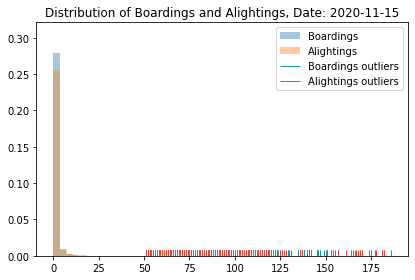

In [ ]:
print(oneday[['PAXUP','PAXDW']].describe())

# fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(x=oneday['PAXUP'], norm_hist = True, kde=False, label='Boardings')
sns.distplot(x=oneday['PAXDW'], norm_hist = True, kde=False, label='Alightings')
sns.rugplot(x=oneday.loc[oneday['PAXUP'] > 50, 'PAXUP'], color='#1995ad', label='Boardings outliers')
sns.rugplot(x=oneday.loc[oneday['PAXDW'] > 50, 'PAXDW'], color='#fa4032', label='Alightings outliers')
plt.title('Distribution of Boardings and Alightings, Date: 2019-11-15')
plt.xlabel('')
plt.legend()
plt.tight_layout()

<p>To get an idea of ​​the error, let's see that in the immediately previous example (a trip in which 76 passengers get off) the vehicle in question has a maximum capacity of 39 passengers. The difficulty with extreme values ​​is that it is not possible to distinguish a false extreme value from a true extreme value (that is, many people get on or off), in addition, it is likely that the vehicles carry a passenger load greater than their maximum capacity, at least in some sections of the route.</p>

In [ ]:
vehi = pd.read_csv('/content/drive/My Drive/ds4a-project/inputs/maestros/vehiculosTPC.csv', 
                   usecols=['IDVEHICULO','CAPPASAJEROS'])
print(vehi.query('IDVEHICULO == 506'))

     IDVEHICULO  CAPPASAJEROS
554         506            39


<p>Below we show the distribution of the maximum reported capacity of the vehicles in the Valle de Aburra transport network.</p>

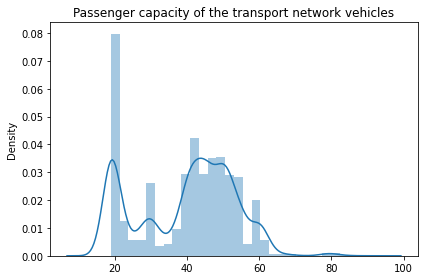

In [ ]:
sns.distplot(x=vehi['CAPPASAJEROS'], norm_hist = True)
plt.title('Passenger capacity of the transport network vehicles')
plt.tight_layout()

### Passengers load by link

<p>That said, let's see the total passenger load per hour and per link for the day we are studying.</p>

In [ ]:
load_by_link = oneday.groupby(['DATEKEY', 'HOUR', 'LINK'], as_index = False).agg({'CARGA': 'sum'})
load_by_link

,DATEKEY,HOUR,LINK,CARGA
0,20191116,0,12013-2603,12
1,20191116,0,12028-2391,5
2,20191116,0,16008-3257,-3
3,20191116,0,2097-16007,1
4,20191116,0,2304-2331,4
...,...,...,...,...
55969,20191116,23,7049-3390,-2
55970,20191116,23,7054-4502,-3
55971,20191116,23,7058-4425,49
55972,20191116,23,7061-4384,-11


<p>As we expected, the passenger load calculated for all the links for each hour of the day is close to zero, since the cases where the variable is positive cancel out with those where the variable is negative. The expected result are positive values ​​that approximate the volume of passengers transported by the transport network vehicles on each link. Similarly, the total passenger load per hour of the day in the entire Valle de Aburra transportation network does not present informative values.</p>

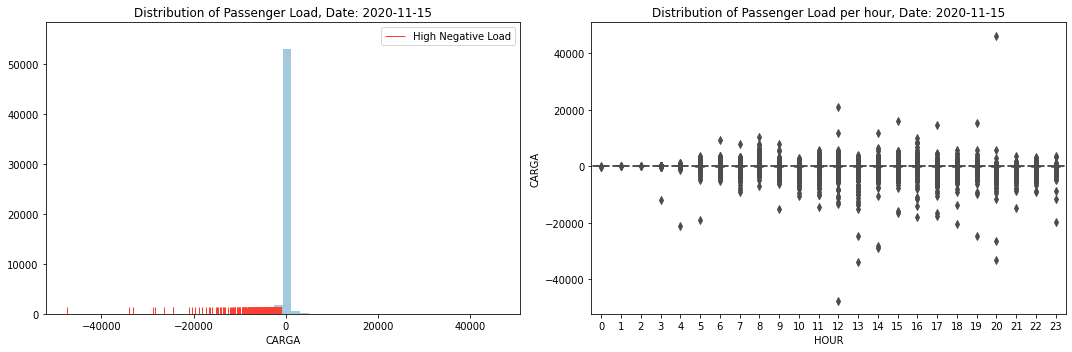

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.distplot(x=load_by_link['CARGA'], hist = True, kde=False, ax=ax[0])
sns.rugplot(x=load_by_link.loc[load_by_link['CARGA'] < -1000, 'CARGA'], 
            color='#fa4032', label='High Negative Load', legend=True, ax=ax[0])
sns.boxplot(x=load_by_link['HOUR'], y=load_by_link['CARGA'], color='b', ax=ax[1])

ax[0].set_title('Distribution of Passenger Load, Date: 2019-11-15')
ax[1].set_title('Distribution of Passenger Load per hour, Date: 2019-11-15')
ax[0].legend()

plt.tight_layout()

<p>Finally, let's find out for this day how many trips reported the same number of passengers getting on and off. This will give an idea of ​​the number of trips on this day that registered passenger movement relatively well. Ideally, the total number of passengers who board a vehicle during the entire route is equal to the total number of passengers alighting.</p>

In [ ]:
travels = grp.agg({'PAXUP':'sum','PAXDW':'sum'})
travels.head(20)

PAXUP  PAXDW
CODIGORUTA SECUENCIARECORRIDO IDVEHICULO              
1001       139472271          491             0      2
           139508261          399             7      3
           139526583          6106          332    692
           139538395          618            58    117
           139548883          550            56     60
           139566074          502            61     59
           139605430          399             0      1
           139631546          502            53     48
           139635589          464             1      1
           139666384          491            39     39
           139673112          585            31     34
           139681311          6103           78     88
           139695392          622             4     32
           139702475          399            62     71
           139737179          6106          422    865
           139752741          6105           33     66
           139765750          6103           47     51
           139775741          6124           48     91
           139793180          6598           58     20
           139812781          6122           61     83

<p>It is obvious that the values ​​do not coincide in many travels recorded on this day, even some travels show large discrepancies. Although we tolerate discrepancies of a maximum of twenty passengers per trip, 22% of the trips on November 15, 2019 present measurement errors in the number of passengers getting on, off or both at the same time. Probably, for other days the results will be similar.</p>

In [ ]:
print('Bad travels (Date: 2019-11-15):', np.mean(np.abs(travels['PAXUP'] - travels['PAXDW']) > 20))

Bad travels (Date: 2019-11-15): 0.22180004749465684


### Conclusions

<p>The distribution of passenger load for the entire time horizon of the dataset is very similar to that presented for a single day.</p>

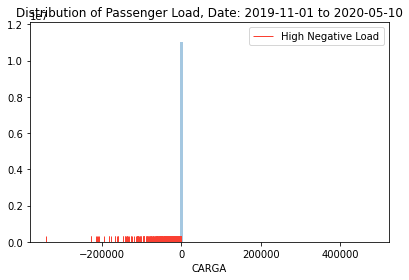

In [ ]:
# loads = pd.read_csv(path_to + 'load_by_link.csv')
sns.distplot(x=loads['CARGA'], hist = True, kde=False, bins=100)
sns.rugplot(x=loads.loc[loads['CARGA'] < -1000, 'CARGA'], 
            color='#fa4032', label='High Negative Load', legend=True)
plt.title('Distribution of Passenger Load, Date: 2019-11-01 to 2020-05-10')
plt.legend()
plt.tight_layout()

<p>In conclusion, the measurement errors at the beginning of a route, the extreme values ​​in the movement of passengers, the impossibility of distinguishing plausible extreme values ​​from the false extreme values, the intermittences in the recording of events and the recording of events in places and in atypical hours they make it difficult to calculate the passenger load per link, day and hour given the cumulative nature of this variable.</p>
<p>For this reason and given the quality of the data, a convenient way to approach the demand that users make of the public transport service in the Aburra Valley network is to explore the behavior of the variable <code>PAXUP</code> (boardings) over time.</p>

# En español:

## Calculation of passenger load and findings in the data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

A continuacion, mostraremos algunos de los inconvenientes que se presentaron en el calculo de la carga de pasajeros por dia, hora y link debido a que la medicion del movimiento de pasajeros es erronea. Basicamente, el mensaje es que cualquier error de medicion se acumula a lo largo de todo el recorrido de un vehiculo que cubre alguna ruta, en un dia de servicio de transporte publico. Una ruta consiste de la sucesion de links (pares de nodos) desde que inicia hasta que finaliza, por lo tanto, si en algun viaje de un vehiculo hay un error de medicion en los primeros links de la ruta, cualquier calculo de la carga de pasajeros en un tramo posterior se verá afectada. Dicho esto, entremos en detalle:

### A single day of information


Cargamos un archivo csv que registra todos los viajes y los eventos de movimiento de pasajeros para un solo día, por ejemplo: 15 de Noviembre de 2019. El archivo previamente fue limpiado y manipulado para que muestrara en sus columnas la informacion relevante, además, a cada evento de movimiento de pasajeros se le ha asignado el link más cercano de acuerdo con sus coordenadas geograficas.

In [ ]:
oneday = pd.read_csv(path + '20191116.csv', usecols = ['DATEKEY', 'CODIGORUTA', 'SECUENCIARECORRIDO', 'IDVEHICULO', 'FECHAREGISTRO', 'HOUR', 'LINK', 'PAXUP', 'PAXDW', 'FAR'])
oneday = oneday.sort_values(by = ['CODIGORUTA','SECUENCIARECORRIDO', 'IDVEHICULO', 'FECHAREGISTRO', 'HOUR'])
oneday.head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK
21,139472271,491,1001,2019-11-16 02:46:56,20191116,2,0,1,False,3776-3772
22,139472271,491,1001,2019-11-16 02:47:25,20191116,2,0,1,False,3776-3772
5061,139508261,399,1001,2019-11-16 05:27:35,20191116,5,3,1,False,3776-3774
5062,139508261,399,1001,2019-11-16 05:27:44,20191116,5,1,0,False,3776-3774
5063,139508261,399,1001,2019-11-16 05:28:13,20191116,5,0,1,False,3776-3772
5064,139508261,399,1001,2019-11-16 05:41:40,20191116,5,2,1,False,3776-3774
5065,139508261,399,1001,2019-11-16 05:42:39,20191116,5,1,0,False,5406-5316
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007


Las columnas SECUENCIARECORRIDO, IDVEHICULO Y CODIGORUTA identifican un determinado recorrido realizado por un vehiculo que cubrio cierta ruta.
Las columnas PAXUP y PAXDW registran el numero de pasajeros que abordaron y descendieron del vehiculo. La columna FAR indica si el evento registrado se presentó a mas de un kilometro de distancia del link mas cercano y LINK muestra el identificador del link mas cercano para cada evento. La columna LINK es fundamental porque asocia cada evento de movimiento de pasajeros a un punto especifico de la red de transporte del Valle de Aburra, lo que a su vez permite aproximar la cantidad de pasajeros que suben y bajan de los vehiculos en un lugar dia y hora especificos.
Eliminar los registros donde FAR == True es otra forma de limpiar datos atipicos.

Lo primero que notamos es un viaje (identificado como 139472271) registrado a una hora no convencional y con una duracion menor a 2 minutos. Este tipo de registros son muy comunes en otra rutas, otros viajes y en otros dias. Adicionalmente, el registro indica que bajaron 2 pasajeros (PAXDW=2) cuando en realidad no subio ninguno (PAXUP=0). El registro de eventos en horas no convencionales y viajes que transmiten informacion intermitente o incompleta a lo largo de una ruta es un problema generalizado en el dataset.

### Unexpected alightings

Veamos ahora un viaje que parece estar completo, por ejemplo el identificado como 139526583, realizado por el vehiculo 6106 y que cubre la ruta 1001. El recorrido inicia cerca de las 5 a.m y reporta el descenso de cuatro pasajeros y despues dos en los link 5404-5405 y 5405-7007, pese a que antes ningun pasajero subio. Este punto es clave: viajes completos, en horas convencionales, reportan al inicio del recorrido descenso de pasajeros, esto significa que la carga calculada de pasajeros es negativa en los links iniciales. Si agregamos todos los viajes que pasan por esos links y si la mayoria reportan un calculo de carga negativa, obtendremos que el volumen total de pasajeros es negativo.

In [ ]:
oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106').head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007
13269,139526583,6106,1001,2019-11-16 04:57:21,20191116,4,4,7,False,7007-5405
13270,139526583,6106,1001,2019-11-16 04:58:19,20191116,4,2,1,False,7032-7033
13271,139526583,6106,1001,2019-11-16 04:58:48,20191116,4,3,14,False,7032-7033
13272,139526583,6106,1001,2019-11-16 04:59:17,20191116,4,3,9,False,7029-7030
13273,139526583,6106,1001,2019-11-16 04:59:46,20191116,4,4,9,False,7029-7030
13274,139526583,6106,1001,2019-11-16 05:00:15,20191116,5,2,9,False,7029-7030
13275,139526583,6106,1001,2019-11-16 05:00:44,20191116,5,1,2,False,7030-7029


Calculemos la carga de pasajeros para el viaje de nuestro ejemplo y veamos que sucede con los errores de medicion.

In [ ]:
oneday['CARGA'] = oneday['PAXUP'] - oneday['PAXDW']
grp = oneday.groupby(['CODIGORUTA', 'SECUENCIARECORRIDO', 'IDVEHICULO'])
oneday['CARGA'] = np.concatenate([np.cumsum(CARGA.values) for i, CARGA in grp['CARGA']])
oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106').head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK,CARGA
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405,-4
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007,-6
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007,-5
13269,139526583,6106,1001,2019-11-16 04:57:21,20191116,4,4,7,False,7007-5405,-8
13270,139526583,6106,1001,2019-11-16 04:58:19,20191116,4,2,1,False,7032-7033,-7
13271,139526583,6106,1001,2019-11-16 04:58:48,20191116,4,3,14,False,7032-7033,-18
13272,139526583,6106,1001,2019-11-16 04:59:17,20191116,4,3,9,False,7029-7030,-24
13273,139526583,6106,1001,2019-11-16 04:59:46,20191116,4,4,9,False,7029-7030,-29
13274,139526583,6106,1001,2019-11-16 05:00:15,20191116,5,2,9,False,7029-7030,-36
13275,139526583,6106,1001,2019-11-16 05:00:44,20191116,5,1,2,False,7030-7029,-37


La columna CARGA retorna la carga de pasajeros despues de cada evento de movimiento de pasajeros. Es evidente que algo anda mal con los datos: una carga negativa es imposible. Pero mas allá de eso, fijemonos como el error de medicion se acumula a lo largo del viaje y en cada link que compone la ruta. Primero, el numero -6 (segunda fila de la columna CARGA) significa que en el LINK 5405-7007 hay -6 pasajeros dentro del vehiculo. Cuando se presenta el siguiente evento en el mismo link (suben tres personas PAXUP=3, bajan dos personas PAXDW=2) el balance continua siendo negativo sin importar si el registro del evento esta vez fue correcto. De modo que, para este viaje los resultados serian: carga de pasajeros de -5 en el link 5405-7007, y carga de pasajeros de -8 en el link siguiente 7007-5405 (-5 del link anterior mas un movimiento neto de -3).
Notemos que la carga de pasajeros de un link depende de la carga de pasajeros del link inmediatamente anterior. Formalmente, para un solo viaje, de cierto vehiculo, en cierta ruta, en determinado dia, la carga de pasajeros del link i es igual a la carga de pasajeros del link i-1 mas el movimiento neto de pasajeros ocurrido en el link i.

### Negative passengers load 

Ahora bien, observemos el final del viaje. Este empezo cerca de las 5 a.m y termino a las 6:20 a.m. La carga del ultimo link del recorrido de esa ruta (identificado 3776-3774) es -360 pasajeros, es decir, que los errores de medicion (bajan mas pasajeros de los que suben) se acumularon durante un hora y veinte minutos de viaje a lo largo de todo el recorrido. Sucesivas cargas negativas resultaran en cargas negativas excesivas al final. Si agregamos estos resultados con los resultados de otros viajes de otras rutas que pasen por los mismos links para un dia y hora determinados, las cantidades negativas se cancelaran con las positivas o las cantidades negativas creceran aun mas. 

In [ ]:
oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106')

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK,CARGA
13266,139526583,6106,1001,2019-11-16 04:55:54,20191116,4,0,4,False,5404-5405,-4
13267,139526583,6106,1001,2019-11-16 04:56:23,20191116,4,0,2,False,5405-7007,-6
13268,139526583,6106,1001,2019-11-16 04:56:52,20191116,4,3,2,False,5405-7007,-5
13269,139526583,6106,1001,2019-11-16 04:57:21,20191116,4,4,7,False,7007-5405,-8
13270,139526583,6106,1001,2019-11-16 04:58:19,20191116,4,2,1,False,7032-7033,-7
...,...,...,...,...,...,...,...,...,...,...,...
13447,139526583,6106,1001,2019-11-16 06:19:22,20191116,6,0,1,False,3776-5316,-360
13448,139526583,6106,1001,2019-11-16 06:20:20,20191116,6,2,3,False,3776-3774,-361
13449,139526583,6106,1001,2019-11-16 06:20:49,20191116,6,5,4,False,3776-3774,-360
13450,139526583,6106,1001,2019-11-16 06:21:07,20191116,6,3,4,False,3776-3772,-361


Observemos tambien que el numero de pasajeros que descendio del vehiculo tomo valores verosimiles a lo largo del viaje (entre 0 y 12) y que en la mayoria de los eventos descendieron entre dos y cuatro personas. No obstante, la carga de pasajeros al final del viaje fue -360, en lugar de cero (el vehiculo debe quedar vacio cuando finaliza el recorrido)

In [ ]:
print(oneday.query('SECUENCIARECORRIDO == 139526583 & IDVEHICULO == 6106').PAXDW.value_counts())

4     30
2     30
3     27
1     27
5     17
0     16
6     13
9      7
7      7
10     4
11     3
14     2
8      2
12     1
Name: PAXDW, dtype: int64


El descenso de pasajeros al comienzo de un viaje puede que no sea el principal problema. En el fragmento del dataset que se presenta a continuacion, notamos que el viaje 139959191 empieza con un descenso de 76 pasajeros, esta cifra arruinaria por completo cualquier calculo. En general, un valor extremo tanto en el numero de pasajeros que suben como en los que bajan distorsiona gravemente el calculo de la carga de pasajeros en un link y en los que le siguen a lo largo del recorrido del vehiculo. De nuevo, imaginemos que agregamos estos resultados para aproximar el volumen de pasajeros en cualquier dia y hora de operacion en determinado link, el resultado obtenido sera muy poco informativo. Cabe anotar, que valores superiores a 50 en las columnas PAXUP y PAXDW representan menos del 1% de la distribucion de estas variables, sin embargo, el efecto negativo acumulado que producen en los calculos es nefasto.

In [ ]:
oneday.query('SECUENCIARECORRIDO == 139959191 & IDVEHICULO == 566').head(10)

,SECUENCIARECORRIDO,IDVEHICULO,CODIGORUTA,FECHAREGISTRO,DATEKEY,HOUR,PAXUP,PAXDW,FAR,LINK,CARGA
303069,139959191,566,1018,2019-11-16 17:52:10,20191116,17,0,76,False,5293-5388,-76
303076,139959191,566,1018,2019-11-16 18:08:03,20191116,18,1,0,False,3718-7050,-75
303078,139959191,566,1018,2019-11-16 18:11:27,20191116,18,1,0,False,5648-3005,-74
303079,139959191,566,1018,2019-11-16 18:14:23,20191116,18,1,0,False,5651-3790,-73
303082,139959191,566,1018,2019-11-16 18:17:17,20191116,18,0,1,False,3784-3783,-74
303083,139959191,566,1018,2019-11-16 18:18:36,20191116,18,1,0,False,2086-2087,-73
303084,139959191,566,1018,2019-11-16 18:25:23,20191116,18,1,1,False,3229-2353,-73
303085,139959191,566,1018,2019-11-16 18:27:17,20191116,18,0,1,False,3021-3743,-74
303086,139959191,566,1018,2019-11-16 18:34:07,20191116,18,0,1,False,4491-2078,-75
303088,139959191,566,1018,2019-11-16 18:37:06,20191116,18,0,1,False,2318-76,-76


               PAXUP          PAXDW
count  414799.000000  414799.000000
mean        1.345980       1.226654
std         5.653624       4.903508
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       170.000000     186.000000


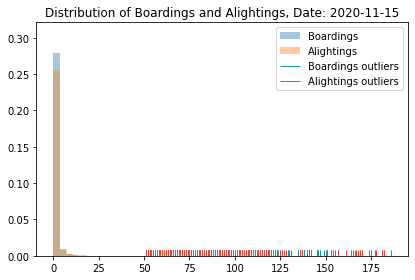

In [ ]:
print(oneday[['PAXUP','PAXDW']].describe())

# fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(x=oneday['PAXUP'], norm_hist = True, kde=False, label='Boardings')
sns.distplot(x=oneday['PAXDW'], norm_hist = True, kde=False, label='Alightings')
sns.rugplot(x=oneday.loc[oneday['PAXUP'] > 50, 'PAXUP'], color='#1995ad', label='Boardings outliers')
sns.rugplot(x=oneday.loc[oneday['PAXDW'] > 50, 'PAXDW'], color='#fa4032', label='Alightings outliers')
plt.title('Distribution of Boardings and Alightings, Date: 2019-11-15')
plt.xlabel('')
plt.legend()
plt.tight_layout()

Para tener una idea del error, veamos que en el ejemplo inmediatamente anterior (un viaje en el que descienden 76 pasajeros) el vehiculo en cuestion tiene una capacidad maxima de 39 pasajeros. La dificultad con los valores extremos es que es dificil distinguir un valor extremo falso de un valor extremo verdadero (es decir, en realidad muchas personas bajan o suben), además, es probable que los vehiculos lleven una carga de pasajeros superior a su capacidad maxima, al menos en algunos tramos del recorrido.

In [ ]:
vehi = pd.read_csv('/content/drive/My Drive/ds4a-project/inputs/maestros/vehiculosTPC.csv', 
                   usecols=['IDVEHICULO','CAPPASAJEROS'])
print(vehi.query('IDVEHICULO == 506'))

     IDVEHICULO  CAPPASAJEROS
554         506            39


A continuacion mostramos la distribucion de la capacidad maxima reportada de los vehiculos de la red de transporte del Valle de Aburra.

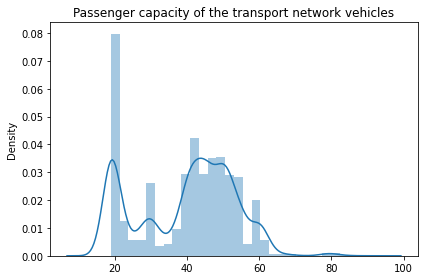

In [ ]:
sns.distplot(x=vehi['CAPPASAJEROS'], norm_hist = True)
plt.title('Passenger capacity of the transport network vehicles')
plt.tight_layout()

### Passengers load by link

Dicho todo lo anterior, veamos la carga total de pasajeros por hora y por link para el día que estamos estudiando.

In [ ]:
load_by_link = oneday.groupby(['DATEKEY', 'HOUR', 'LINK'], as_index = False).agg({'CARGA': 'sum'})
load_by_link

,DATEKEY,HOUR,LINK,CARGA
0,20191116,0,12013-2603,12
1,20191116,0,12028-2391,5
2,20191116,0,16008-3257,-3
3,20191116,0,2097-16007,1
4,20191116,0,2304-2331,4
...,...,...,...,...
55969,20191116,23,7049-3390,-2
55970,20191116,23,7054-4502,-3
55971,20191116,23,7058-4425,49
55972,20191116,23,7061-4384,-11


Como esperabamos, la carga de pasajeros calculada para todos los links para cada hora del dia es cercana a cero, ya que los casos donde la variable es positiva se anulan con aquellos donde la variable es negativa. El resultado esperado son valores positivos que aproximen el volumen de pasajeros que transportan los vehiculos de la red de transporte en cada link. Del mismo modo, la carga total de pasajeros por hora del dia en toda la red de transporte del Valle de Aburra no presenta valores informativos.

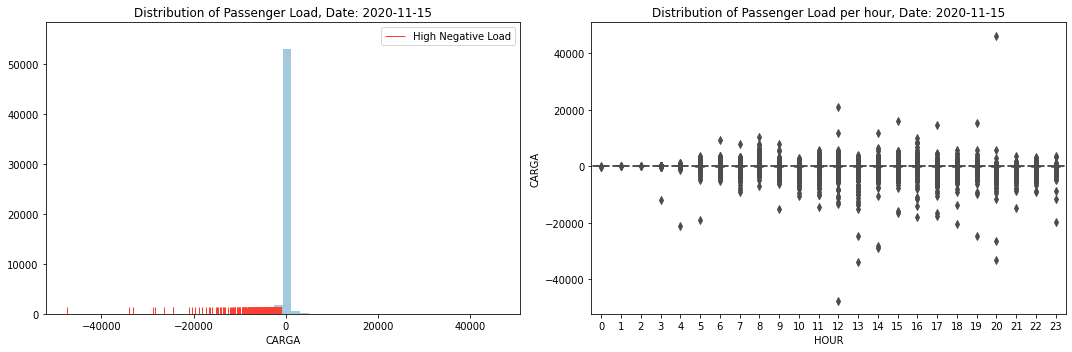

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.distplot(x=load_by_link['CARGA'], hist = True, kde=False, ax=ax[0])
sns.rugplot(x=load_by_link.loc[load_by_link['CARGA'] < -1000, 'CARGA'], 
            color='#fa4032', label='High Negative Load', legend=True, ax=ax[0])
sns.boxplot(x=load_by_link['HOUR'], y=load_by_link['CARGA'], color='b', ax=ax[1])

ax[0].set_title('Distribution of Passenger Load, Date: 2019-11-15')
ax[1].set_title('Distribution of Passenger Load per hour, Date: 2019-11-15')
ax[0].legend()

plt.tight_layout()

Finalmente, averiguemos para este dia cuantos viajes reportaron igual cantidad de pasajeros que suben y que bajan. Esto dará una idea de la cantidad de viajes en este dia que registraron relativamente bien el movimiento de pasajeros. Lo ideal es que el total de pasajeros que abordan un vehiculo durante todo el recorrido sea igual al total de pasajeros que descienden.

In [ ]:
travels = grp.agg({'PAXUP':'sum','PAXDW':'sum'})
travels.head(20)

PAXUP  PAXDW
CODIGORUTA SECUENCIARECORRIDO IDVEHICULO              
1001       139472271          491             0      2
           139508261          399             7      3
           139526583          6106          332    692
           139538395          618            58    117
           139548883          550            56     60
           139566074          502            61     59
           139605430          399             0      1
           139631546          502            53     48
           139635589          464             1      1
           139666384          491            39     39
           139673112          585            31     34
           139681311          6103           78     88
           139695392          622             4     32
           139702475          399            62     71
           139737179          6106          422    865
           139752741          6105           33     66
           139765750          6103           47     51
           139775741          6124           48     91
           139793180          6598           58     20
           139812781          6122           61     83

Es obvio que los valores no coinciden en muchos recorridos registrados en este dia, incluso, algunos recorridos presentan grandes discrepancias. Aunque toleremos discrepancias de a lo sumo veinte pasajeros por viaje, el 22% de los recorridos el dia 15 de Noviembre de 2019 presentan errores de medicion en el numero de pasajeros que suben, que bajan o en ambos al mismo tiempo. Probablemente, para otros días los resultados sean similares.

In [ ]:
print('Bad travels (Date: 2019-11-15):', np.mean(np.abs(travels['PAXUP'] - travels['PAXDW']) > 20))

Bad travels (Date: 2019-11-15): 0.22180004749465684


### Conclusions

La distribución de la carga de pasajeros para todo el horizonte temporal del dataset es muy similar a la que presentamos para un solo dia.

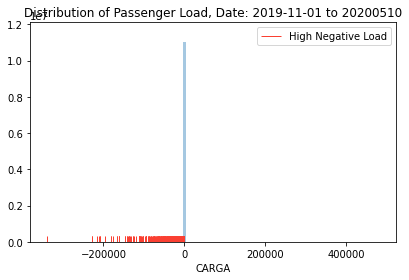

In [ ]:
# loads = pd.read_csv(path_to + 'load_by_link.csv')
sns.distplot(x=loads['CARGA'], hist = True, kde=False, bins=100)
sns.rugplot(x=loads.loc[loads['CARGA'] < -1000, 'CARGA'], 
            color='#fa4032', label='High Negative Load', legend=True)
plt.title('Distribution of Passenger Load, Date: 2019-11-01 to 20200510')
plt.legend()
plt.tight_layout()

En conclusion, los errores de medicion al comienzo de un recorrido, los valores extremos en el movimiento de pasajeros, la imposibilidad de distinguir valores extremos verosimiles de los valores extremos falsos, las intermitencias en el registro de los eventos y el registro de eventos en lugares y en horas atipicas dificultan el calculo de la carga de pasajeros por link, dia y hora dada la naturaleza acumulativa de esta variable. 
Por esta razon y ante la calidad de los datos, una forma conveniente de aproximarnos a la demanda que los usuarios hacen del servicio de transporte publico en la red del Valle de Aburra es explorar el comportamiento de la variable PAXUP, es decir, los abordajes. 